Call Option Price: 10.450583572185565
Put Option Price: 5.573526022256971
JPM Historical Volatility: 0.19908588026307392
Call Delta: 0.6368306511756191
Put Delta: -0.3631693488243809


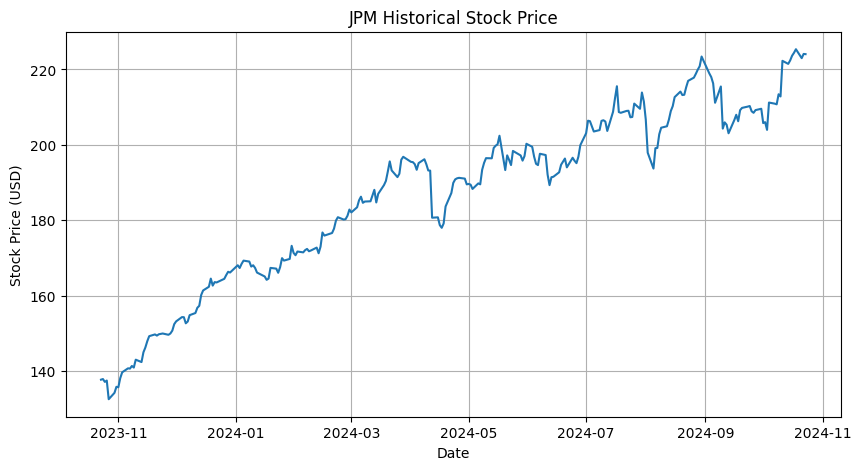

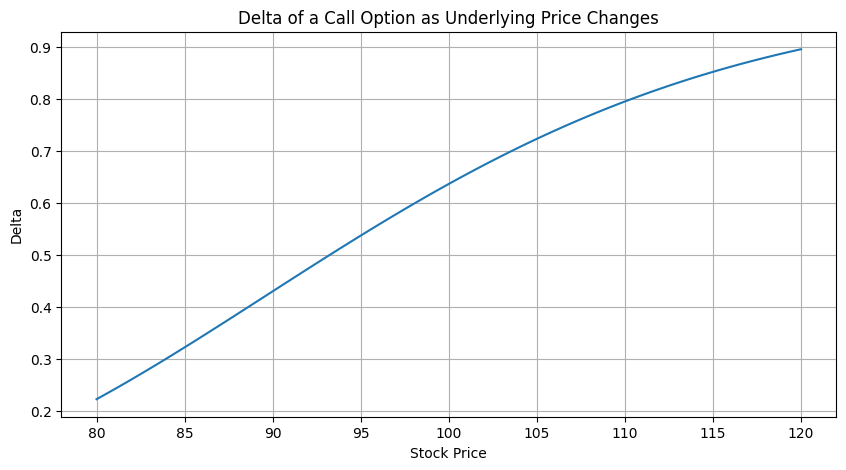

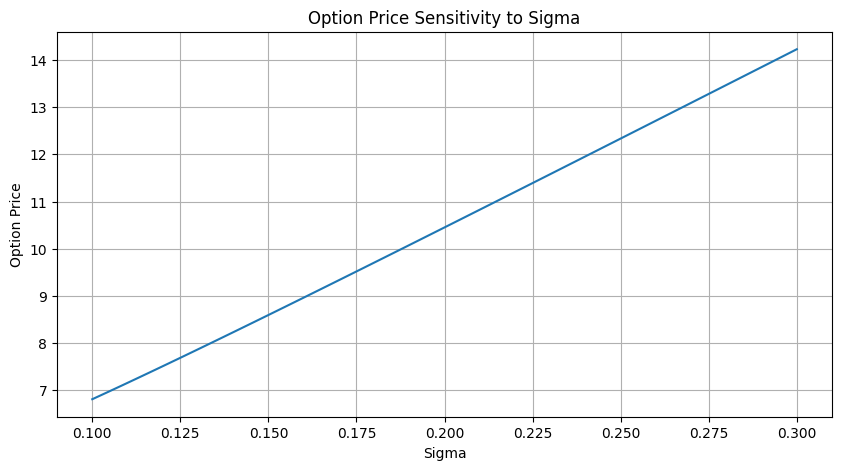

In [2]:
import yfinance as yf
import numpy as np
import scipy.stats as si
import matplotlib.pyplot as plt
import mplfinance as mpf
import plotly.graph_objects as go
from datetime import datetime

def fetch_options_data(ticker_symbol):
    ticker = yf.Ticker(ticker_symbol)
    options_dates = ticker.options
    # We'll use the nearest expiry date for our analysis
    options_data = ticker.option_chain(options_dates[0])
    return options_data.calls, options_data.puts

def fetch_historical_stock_data(ticker_symbol, period="1y"):
    ticker = yf.Ticker(ticker_symbol)
    stock_data = ticker.history(period=period)
    
    if stock_data.empty:
        raise ValueError(f"No historical stock data found for ticker '{ticker_symbol}'.")
    return stock_data
ticker_symbol = "JPM"

jpm_stock_data = fetch_historical_stock_data(ticker_symbol, period="1y")

plt.figure(figsize=(10, 5))
plt.plot(jpm_stock_data['Close'])
plt.title('JPM Historical Stock Price')
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.grid(True)


# Example usage:
jpm_calls, jpm_puts = fetch_options_data(ticker_symbol)



# %%
class BlackScholesModel:
    def __init__(self, S, K, T, r, sigma):
        self.S = S        # Underlying asset price
        self.K = K        # Option strike price
        self.T = T        # Time to expiration in years
        self.r = r        # Risk-free interest rate
        self.sigma = sigma  # Volatility of the underlying asset

    def d1(self):
        return (np.log(self.S / self.K) + (self.r + 0.5 * self.sigma ** 2) * self.T) / (self.sigma * np.sqrt(self.T))
    
    def d2(self):
        return self.d1() - self.sigma * np.sqrt(self.T)
    
    def call_option_price(self):
        return (self.S * si.norm.cdf(self.d1(), 0.0, 1.0) - self.K * np.exp(-self.r * self.T) * si.norm.cdf(self.d2(), 0.0, 1.0))
    
    def put_option_price(self):
        return (self.K * np.exp(-self.r * self.T) * si.norm.cdf(-self.d2(), 0.0, 1.0) - self.S * si.norm.cdf(-self.d1(), 0.0, 1.0))

# Example usage:
bsm = BlackScholesModel(S=100, K=100, T=1, r=0.05, sigma=0.2)
print(f"Call Option Price: {bsm.call_option_price()}")
print(f"Put Option Price: {bsm.put_option_price()}")

# %%
def calculate_historical_volatility(stock_data, window=252):
    log_returns = np.log(stock_data['Close'] / stock_data['Close'].shift(1))
    volatility = np.sqrt(window) * log_returns.std()
    return volatility

jpm_volatility = calculate_historical_volatility(jpm_stock_data)
print(f"JPM Historical Volatility: {jpm_volatility}")

# %%
class BlackScholesGreeks(BlackScholesModel):
    def delta_call(self):
        return si.norm.cdf(self.d1(), 0.0, 1.0)

    def delta_put(self):
        return -si.norm.cdf(-self.d1(), 0.0, 1.0)
    
    def gamma(self):
        return si.norm.pdf(self.d1(), 0.0, 1.0) / (self.S * self.sigma * np.sqrt(self.T))

    def theta_call(self):
        return (-self.S * si.norm.pdf(self.d1(), 0.0, 1.0) * self.sigma / (2 * np.sqrt(self.T)) - self.r * self.K * np.exp(-self.r * self.T) * si.norm.cdf(self.d2(), 0.0, 1.0))
    
    def theta_put(self):
        return (-self.S * si.norm.pdf(self.d1(), 0.0, 1.0) * self.sigma / (2 * np.sqrt(self.T)) + self.r * self.K * np.exp(-self.r * self.T) * si.norm.cdf(-self.d2(), 0.0, 1.0))

    def vega(self):
        return self.S * si.norm.pdf(self.d1(), 0.0, 1.0) * np.sqrt(self.T)
    
    def rho_call(self):
        return self.K * self.T * np.exp(-self.r * self.T) * si.norm.cdf(self.d2(), 0.0, 1.0)
    
    def rho_put(self):
        return -self.K * self.T * np.exp(-self.r * self.T) * si.norm.cdf(-self.d2(), 0.0, 1.0)

# Example usage:
bsg = BlackScholesGreeks(S=100, K=100, T=1, r=0.05, sigma=0.2)
print(f"Call Delta: {bsg.delta_call()}")
print(f"Put Delta: {bsg.delta_put()}")

# %%
# Define a range of stock prices
stock_prices = np.linspace(80, 120, 100)
deltas = [BlackScholesGreeks(S=price, K=100, T=1, r=0.05, sigma=0.2).delta_call() for price in stock_prices]

plt.figure(figsize=(10, 5))
plt.plot(stock_prices, deltas)
plt.title('Delta of a Call Option as Underlying Price Changes')
plt.xlabel('Stock Price')
plt.ylabel('Delta')
plt.grid(True)

# %%
def plot_option_sensitivity(bs_model, parameter, values, option_type='call'):
    prices = []
    for value in values:
        setattr(bs_model, parameter, value)
        if option_type == 'call':
            prices.append(bs_model.call_option_price())
        else:
            prices.append(bs_model.put_option_price())

    plt.figure(figsize=(10, 5))
    plt.plot(values, prices)
    plt.title(f'Option Price Sensitivity to {parameter.capitalize()}')
    plt.xlabel(parameter.capitalize())
    plt.ylabel('Option Price')
    plt.grid(True)
    
# Example usage:
volatilities = np.linspace(0.1, 0.3, 100)
plot_option_sensitivity(bsm, 'sigma', volatilities, 'call')